# Testing CNN Shape Measurement Responsivity of Simple Galaxy Models

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.stats import gaussian_kde, pearsonr

#tensorflow
import tensorflow as tf
#config = tf.compat.v1.ConfigProto()
#config.gpu_options.allow_growth = True
#sess = tf.compat.v1.Session(config=config)
#print("Tensorflow version: {}".format(tf.version.VERSION))

#keras only after gpu ID and memory usage is set
import tensorflow.keras.optimizers as ko
import galsim
import tensorflow_datasets as tfds
import autometacal as amc
import learnr

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Load Data

In [3]:
from autometacal.python.datasets import GalGen

In [4]:
batch_size=64
data= tfds.load('GalGen/small_stamp_100k')
data = data['train'].cache()
data = data.repeat()
data = data.shuffle(1000)
data = data.batch(batch_size)
data = data.prefetch(tf.data.experimental.AUTOTUNE)

In [5]:
batchit = data.as_numpy_iterator()
onebatch = batchit.next()

reconv_psf = galsim.Moffat(beta=2.5, fwhm=0.9*1.2)

reconv_psf_image = tf.expand_dims(tf.convert_to_tensor(reconv_psf.drawImage(nx=51, ny=51, scale=.2).array),axis=0)
gal_images,psf_images = onebatch['obs_image'],onebatch['psf_image'] 

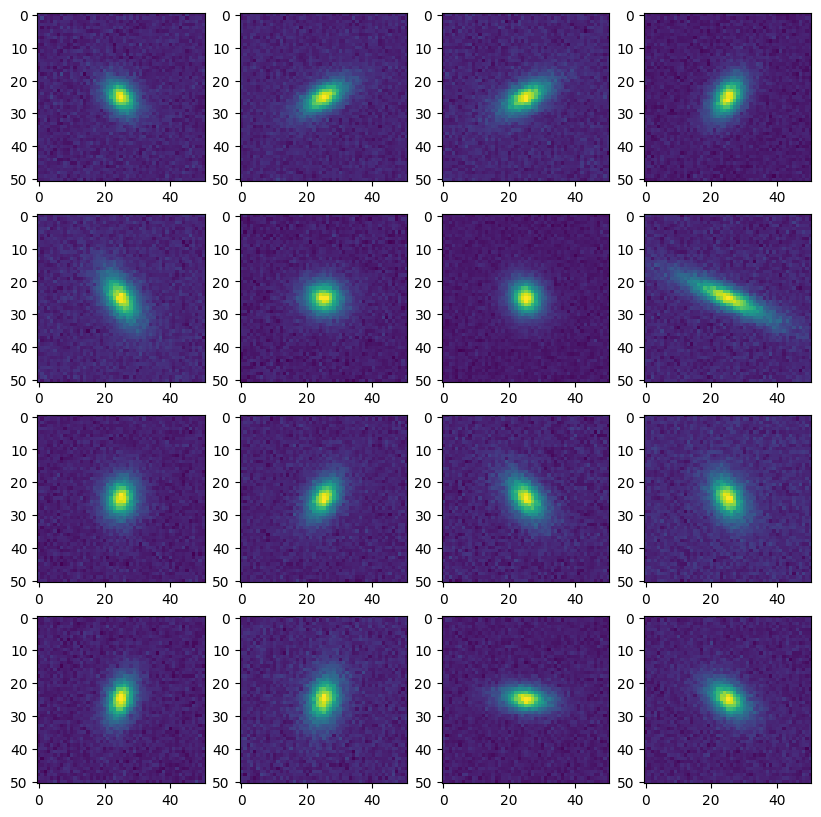

In [6]:
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(gal_images[i])

### Test with finitediff

In [7]:
model = learnr.Ribli19(51,n_channels=1)

In [15]:
@tf.function
def loss_fd(batch,reconv_psf,model,shear_range=.1):
  """
   Defines a loss respective to unit shear response
   
  Args:
    obs, psf _batch: tf batch 
      obs images and psfs
      
    reconv_psf_image: tf tensor 
      Synthetic reconvolution psf
    step: float
      Step size for the finite differences
     
  Returns:
    lost: float
      Distance between the shear response matrix and unity.
  """
  obs_batch, psf_batch = batch
  batch_size = obs_batch.shape[0]   
  shears = tf.random.uniform((batch_size,2),-shear_range,shear_range,dtype=tf.float32)
  #compute response
  R = learnr.get_metacal_response_finitediff(obs_batch,
                                      psf_batch,
                                      reconv_psf,
                                      shear=shears,
                                      step=0.01,
                                      method=model)[1]
  #R = amc.get_metacal_response(...)[1]
  
  lost = tf.norm(R - tf.eye(2),ord=2)
  
  return lost

loss = loss_fd
batch =onebatch['gal_model'],onebatch['psf_image']
loss(batch,reconv_psf_image,model)

<tf.Tensor: shape=(), dtype=float32, numpy=11.313708>

In [18]:
@tf.function
def step():
  
  with tf.GradientTape() as tape:
    tape.watch(model.trainable_variables)
       
    lost = loss(batch,reconv_psf_image,model)
 
  grads = tape.gradient(lost, model.trainable_variables)

  opt.apply_gradients(zip(grads, model.trainable_variables))
  return lost

opt = ko.Adam(learning_rate=1e-4)

In [20]:
step()

<tf.Tensor: shape=(), dtype=float32, numpy=11.313708>

In [ ]:
lost = []
its = []
iterations = 1000
for it in range(iterations):
  batch = batchit.next()
  singlebatch =batch['gal_model'],batch['psf_image']
  nowlost = step(singlebatch,loss,model)
  if not it%10:
    print(f"{nowlost: .4f},   {it}  ",end='\r')
    lost.append(nowlost)
    its.append(it)  
model.save("RLmodel.model")

In [ ]:
style.use('ggplot')
plot(its,lost)
xlabel('iterations')
ylabel('loss')
savefig(f'learningRloss{time.time()}.png',bbox_inches='tight')

In [ ]:
garray_list = []
e_auto_list = []
R_auto_list = []
for n in tqdm.tqdm(range(10)):
  batch = batchit.next()
  garray=batch['label']
  garray_list.append(garray)
  e_auto, R_auto = amc.get_metacal_response(batch['obs_image'],batch['psf_image'],reconv_psf_image,model)
  e_auto_list.append(e_auto)
  R_auto_list.append(R_auto)

In [ ]:
garray=tf.concat(garray_list,axis=0)
e_auto=tf.concat(e_auto_list,axis=0)
R_auto=tf.concat(R_auto_list,axis=0)

In [ ]:
np.save("garray.npy",garray.numpy())
np.save("e_auto.npy",e_auto.numpy())
np.save("R_auto.npy",R_auto.numpy())

In [ ]:
calibre_f=mean(tf.linalg.inv(R_auto[:]),axis=0) @ tf.reshape(e_auto,[-1,2,1])

In [ ]:
mean(tf.linalg.inv(R_auto[:]),axis=0)

In [ ]:
figure(figsize=(20,10))
style.use('ggplot')
subplot(121)

x1 = garray[:,0]
x2 = garray[:,1]

y1 = e_auto[:,0]
y1corr = calibre_f[:,0,0]

y2 = e_auto[:,1]
y2corr = calibre_f[:,1,0]

#linear fit
poly_g1 = np.polyfit(x1,y1,1)
poly_g2 = np.polyfit(x2,y2,1)


poly_g1corr = np.polyfit(x1,y1corr,1)
poly_g2corr = np.polyfit(x2,y2corr,1)


#correlation coefficient
corr_g1 = pearsonr(x1,y1)
corr_g2 = pearsonr(x2,y2)


corr_g1corr = pearsonr(x1,y1corr)
corr_g2corr = pearsonr(x2,y2corr)


scatter(x1,y1-x1-mean(y1),alpha=.7,label="uncalibrated")
scatter(x1,y1corr-x1-mean(y1corr),alpha=.7,label="autometacal")
text(-.6,0.4, "$m_1$ = {:.2e},  $c_1$ = {:.2f}, r = {:.3f} (uncorrected)".format(1-poly_g1[0],poly_g1[1],corr_g1[0]),fontsize=15)
text(-.6,0.2, "$m_1$ = {:.2e},  $c_1$ = {:.2f}, r = {:.3f} (amc)".format(1-poly_g1corr[0],poly_g1corr[1],corr_g1corr[0]),fontsize=15)



title("$e_1$ ellipticity measurements", fontsize=20)
xlabel("truth",fontsize=20)
ylabel(" rescaled residuals ($y-x-\\langle y \\rangle $)",fontsize=20)
legend(fontsize=20,loc=3)
xlim(-0.7,0.7)
ylim(-0.7,0.7)

subplot(122)

scatter(x2,y2-x2-mean(y2),alpha=.7,label="uncalibrated")
scatter(x2,y2corr-x2-mean(y2corr),alpha=.7,label="autometacal")
text(-.6,0.4 , "$m_2$ = {:.2e},  $c_2$ = {:.2f}, r = {:.3f} (uncorrected) ".format(1-poly_g2[0],poly_g2[1],corr_g2[0]),fontsize=15)
text(-.6,0.2 , "$m_2$ = {:.2e},  $c_2$ = {:.2f}, r = {:.3f} (amc)".format(1-poly_g2corr[0],poly_g2corr[1],corr_g2corr[0]),fontsize=15)

title("$e_2$ ellipticity measurements", fontsize=20)
xlabel("truth",fontsize=20)

legend(fontsize=20,loc=3)
xlim(-0.7,0.7)
ylim(-0.7,0.7)
savefig(f"linearity{time.time()}.pdf",bbox_inches="tight")

In [ ]:
style.use('ggplot')
figure(figsize=(20,8))
subplot(122)
hist(R_auto[:,0,0].numpy()[:],bins=30,density=True,label="$R_{11}$");
hist(R_auto[:,1,1].numpy()[:],bins=30,density=True,label="$R_{22}$",alpha=.7);
title("autometacal response matrix (1k obj),  diagonal",fontsize=20)
legend(fontsize=20)
subplot(121)
hist(R_auto[:,1,0].numpy()[:],bins=30,label="$R_{21}$",density=True);
hist(R_auto[:,0,1].numpy()[:],bins=30,label="$R_{12}$",density=True,alpha=.7);
title("autometacal response matrix (1k obj), off diagonal",fontsize=20)
legend(fontsize=20)
savefig(f'response_distribution_newmodel{time.time()}.pdf',bbox_inches='tight')

## New loss (apply shear before noise, PSF, etc.)

In [ ]:
import galflow as gf

In [ ]:
batch_size=64
data= tfds.load('GalGen/small_stamp_100k')
data = data['train'].cache()
data = data.repeat()
data = data.shuffle(1000)
data = data.batch(batch_size)
data = data.prefetch(tf.data.experimental.AUTOTUNE)
batchit = data.as_numpy_iterator()

In [ ]:
import galflow as gf
@tf.function
def generate_real_mcal_image(
  gal_images,
  reconvolution_psf_image,
  g
):
  """ Generate a metacalibrated image given input and target PSFs.
  
  Args: 
    gal_images: tf.Tensor or np.array
      (batch_size, N, N ) image of galaxies
    psf_images: tf.Tensor or np.array
      (batch_size, N, N ) image of psf model
    reconvolution_psf_image: tf.Tensor
      (N, N ) tensor of reconvolution psf model
    g: tf.Tensor or np.array
    [batch_size, 2] input shear
  Returns:
    img: tf.Tensor
      tf tensor containing image of galaxy after deconvolution by psf_deconv, 
      shearing by g, and reconvolution with reconvolution_psf_image.
  
  """
  #cast stuff as float32 tensors
  gal_images = tf.convert_to_tensor(gal_images, dtype=tf.float32)  
  #psf_images = tf.convert_to_tensor(psf_images, dtype=tf.float32) 
  reconvolution_psf_image = tf.convert_to_tensor(reconvolution_psf_image, dtype=tf.float32)  
  g = tf.convert_to_tensor(g, dtype=tf.float32)  
  
  #Get batch info
  batch_size, nx, ny = gal_images.get_shape().as_list()  
      
  #add pads in real space
  padfactor = 3 #total width of image after padding
  fact = (padfactor - 1)//2 #how many image sizes to one direction
  paddings = tf.constant([[0, 0,], [nx*fact, nx*fact], [ny*fact, ny*fact]])
    
  padded_gal_images = tf.pad(gal_images,paddings)
  padded_psf_images = tf.pad(psf_images,paddings)
  padded_reconvolution_psf_image = tf.pad(reconvolution_psf_image,paddings)
    
  #Convert galaxy images to k space
  im_shift = tf.signal.ifftshift(padded_gal_images,axes=[1,2]) # The ifftshift is to remove the phase for centered objects
  im_complex = tf.cast(im_shift, tf.complex64)
  im_fft = tf.signal.fft2d(im_complex)
  imk = tf.signal.fftshift(im_fft, axes=[1,2])#the fftshift is to put the 0 frequency at the center of the k image
  
  #Convert psf images to k space  
  #psf_complex = tf.cast(padded_psf_images, tf.complex64)
  #psf_fft = tf.signal.fft2d(psf_complex)
  #psf_fft_abs = tf.abs(psf_fft)
  #psf_fft_abs_complex = tf.cast(psf_fft_abs,tf.complex64)
  #kpsf = tf.signal.fftshift(psf_fft_abs_complex,axes=[1,2])

  #Convert reconvolution psf image to k space 
  rpsf_complex = tf.cast(padded_reconvolution_psf_image, tf.complex64)
  rpsf_fft =  tf.signal.fft2d(rpsf_complex)
  rpsf_fft_abs = tf.abs(rpsf_fft)
  psf_fft_abs_complex = tf.cast(rpsf_fft_abs,tf.complex64)
  krpsf = tf.signal.fftshift(psf_fft_abs_complex,axes=[1,2])

  # Compute Fourier mask for high frequencies
  # careful, this is not exactly the correct formula for fftfreq
  kx, ky = tf.meshgrid(tf.linspace(-0.5,0.5,padfactor*nx),
                       tf.linspace(-0.5,0.5,padfactor*ny))
  mask = tf.cast(tf.math.sqrt(kx**2 + ky**2) <= 0.5, dtype='complex64')
  mask = tf.expand_dims(mask, axis=0)

  # Deconvolve image from input PSF
  im_deconv = imk * mask #* ( (1./(kpsf+1e-10))*mask)

  # Apply shear
  im_sheared = gf.shear(tf.expand_dims(im_deconv,-1), g[...,0], g[...,1])[...,0]

  # Reconvolve with target PSF
  im_reconv = tf.signal.ifft2d(tf.signal.ifftshift(im_sheared * krpsf * mask))

  # Compute inverse Fourier transform
  img = tf.math.real(tf.signal.fftshift(im_reconv))
  
  # Add noise
  img = img[:,fact*nx:-fact*nx,fact*ny:-fact*ny]
  img += tf.random.normal([nx,ny],0,1e-6)

  return img

In [ ]:
style.use('default')
imshow(onebatch['gal_model'][0])

In [ ]:
teste=generate_real_mcal_image(onebatch['gal_model'][0][tf.newaxis],reconv_psf_image,[[0.0,0.5]])

In [ ]:
imshow(teste[0])

In [ ]:
newmodel = Ribli19(51)

In [ ]:
@tf.function
def lossnewmodel(batch,model):
  
  shears = tf.random.uniform((batch_size,2),-.1,.1,dtype=tf.float32)
  #compute response
 
  R = get_real_metacal_response_finitediff(batch['gal_model'],
                                      reconv_psf_image,
                                      shear=shears,
                                      step=0.01,
                                      method=model)[1]
  
  lost = tf.norm(R - tf.eye(2)) 
  return lost, tf.reduce_mean(R,axis=0)

In [ ]:
@tf.function
def stepnewmodel(batch):
  
  with tf.GradientTape() as tape:
    tape.watch(newmodel.trainable_variables)
       
    lost, meanR = lossnewmodel(batch,newmodel)
 
  grads = tape.gradient(lost, newmodel.trainable_variables)
  opt.apply_gradients(zip(grads, newmodel.trainable_variables))
  return lost, meanR
opt = ko.Adam(learning_rate=1e-4)

In [ ]:
stepnewmodel(onebatch)

In [ ]:
lost2 = []
its2 = []
iterations = 10000
for it in range(iterations):
  batch = batchit.next()
  nowlost, meanR = stepnewmodel(batch)
  if not it%10:
    print(f"{nowlost: .4f},   {it}  ",end='\r')
    lost2.append(nowlost)
    its2.append(it)  


In [ ]:
stepnewmodel(onebatch)

In [ ]:
newmodel.save("RLnewmodelclipping.model")

In [ ]:
style.use('ggplot')
plot(its2,lost2,label='finitediff')
xlabel('iterations')
ylabel('loss')
yscale('log')
legend()
savefig(f'learningnewmodel4{time.time()}.png',bbox_inches='tight')

In [ ]:
garray_list = []
e_auto_list = []
R_auto_list = []
for n in tqdm.tqdm(range(100)):
  batch = batchit.next()
  garray=batch['label']
  garray_list.append(garray)
  e_auto, R_auto = amc.get_metacal_response(batch['obs_image'],batch['psf_image'],reconv_psf_image,newmodel)
  e_auto_list.append(e_auto)
  R_auto_list.append(R_auto)  

In [ ]:
garray=tf.concat(garray_list,axis=0)
e_auto=tf.concat(e_auto_list,axis=0)
R_auto=tf.concat(R_auto_list,axis=0)

In [ ]:
np.save("garraynewmodel.npy",garray.numpy())
np.save("e_autonewmodel.npy",e_auto.numpy())
np.save("R_autonewmodel.npy",R_auto.numpy())

In [ ]:
calibre_f=mean(tf.linalg.inv(R_auto[:]),axis=0) @ tf.reshape(e_auto,[-1,2,1])

In [ ]:
figure(figsize=(15,15))
style.use('ggplot')


x1 = garray[:,0]
x2 = garray[:,1]

y1 = e_auto[:,0]
y1corr = calibre_f[:,0,0]

y2 = e_auto[:,1]
y2corr = calibre_f[:,1,0]

#linear fit
poly_g1 = np.polyfit(x1,y1,1)
poly_g2 = np.polyfit(x2,y2,1)


poly_g1corr = np.polyfit(x1,y1corr,1)
poly_g2corr = np.polyfit(x2,y2corr,1)


#correlation coefficient
corr_g1 = pearsonr(x1,y1)
corr_g2 = pearsonr(x2,y2)


corr_g1corr = pearsonr(x1,y1corr)
corr_g2corr = pearsonr(x2,y2corr)


subplot(221)
scatter(x1,y1-mean(y1),alpha=.5,label="uncalibrated")
text(-.6,0.4, "$m_1$ = {:.2e},  $c_1$ = {:.2f}, r = {:.3f}".format(1-poly_g1[0],poly_g1[1],corr_g1[0]),fontsize=15)

title("$e_1$ \"ellipticity\" measurements", fontsize=20)
xlabel("truth",fontsize=20)
ylabel(" rescaled results ($y - \\langle y \\rangle $)",fontsize=20)
legend(fontsize=20,loc=3)


subplot(223)
scatter(x1,y1corr-x1-mean(y1corr),alpha=.5,label="autometacal")
text(-.6,0.2, "$m_1$ = {:.2e},  $c_1$ = {:.2f}, r = {:.3f} (amc)".format(1-poly_g1corr[0],poly_g1corr[1],corr_g1corr[0]),fontsize=15)


xlabel("truth",fontsize=20)
ylabel(" rescaled residuals ($y - x - \\langle y \\rangle $)",fontsize=20)
legend(fontsize=20,loc=3)
xlim(-0.7,0.7)
ylim(-0.7,0.7)

subplot(222)

scatter(x2,y2-mean(y2),alpha=.5,label="uncalibrated")
text(-.6,0.4 , "$m_2$ = {:.2e},  $c_2$ = {:.2f}, r = {:.3f}".format(1-poly_g2[0],poly_g2[1],corr_g2[0]),fontsize=15)

title("$e_2$ \"ellipticity\" measurements", fontsize=20)
xlabel("truth",fontsize=20)
legend(fontsize=20,loc=3)


subplot(224)
scatter(x2,y2corr-x2-mean(y2corr),alpha=.5,label="autometacal")
text(-.6,0.2 , "$m_2$ = {:.2e},  $c_2$ = {:.2f}, r = {:.3f} (amc)".format(1-poly_g2corr[0],poly_g2corr[1],corr_g2corr[0]),fontsize=15)

xlim(-0.7,0.7)
ylim(-0.7,0.7)
xlabel("truth",fontsize=20)
legend(fontsize=20,loc=3)
savefig(f"prednewmodel{time.time()}.png",bbox_inches="tight")

In [ ]:
style.use('ggplot')
figure(figsize=(20,8))
subplot(122)
hist(R_auto[:,0,0].numpy()[:],bins=30,density=True,label="$R_{11}$");
hist(R_auto[:,1,1].numpy()[:],bins=30,density=True,label="$R_{22}$",alpha=.7);
title("response matrix (640 obj),  diagonal",fontsize=20)
legend(fontsize=20)
subplot(121)
hist(R_auto[:,1,0].numpy()[:],bins=30,label="$R_{21}$",density=True);
hist(R_auto[:,0,1].numpy()[:],bins=30,label="$R_{12}$",density=True,alpha=.7);
title("response matrix 640, off diagonal",fontsize=20)
legend(fontsize=20)
savefig(f'response_distribution_newmodel{time.time()}.pdf',bbox_inches='tight')

In [ ]:
banana();

## Testing the trained model in the wild: